# Coursework 1 - Decision Trees Learning and K-Nearest Neighbors

### Candidate number: 670021141

## Summary
In this coursework, your task is to develop a machine learning classifier for predicting female patients that at high risk of Diabetes. Your model is to support clinicians in identifying patients who are likely to have “Diabetes”. The dataset has 9 attributes in total including the “target/label” attribute. The full dataset is available on ELE under assessment coursework 1. The dataset consists of the following: 


## Dataset

1. preg: Number of times pregnant
2. plas: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. pres: Diastolic blood pressure (mm Hg)
4. skin: Triceps skin fold thickness (mm)
5. insu: 2-Hour serum insulin (mu U/ml)
6. mass: Body mass index (weight in kg/(height in m)^2)
7. pedi: Diabetes pedigree function
8. age: Age (years)
9. class: Class variable (0 or 1)

In [1]:
import pandas as pd
dia_all = pd.read_csv("diabetes.txt") # This loads the full dataset 
                 # In the file, attributes are separated by ,

In [2]:
dia_all

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,tested_negative
764,2,122,70,27,0,36.8,0.340,27,tested_negative
765,5,121,72,23,112,26.2,0.245,30,tested_negative
766,1,126,60,0,0,30.1,0.349,47,tested_positive


## Seperate the input (attributes) from target (label)

In [3]:
sourcevars = dia_all.iloc[:,:-1] #all rows + all columns except the last one
targetvar = dia_all.iloc[:,-1:] #all rows + only the last column

In [4]:
sourcevars.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [5]:
targetvar.head()

,class
0,tested_positive
1,tested_negative
2,tested_positive
3,tested_negative
4,tested_positive


   # Task 1 - Exploratory data analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from pylab import rcParams
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [7]:
# First lets explore the summary statistics for each input attribute:


sourcevars.aggregate([max, min, sum, np.mean, np.std]).head()


,preg,plas,pres,skin,insu,mass,pedi,age
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
sum,2953.000000,92847.000000,53073.000000,15772.000000,61286.000000,24570.300000,362.401000,25529.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232


In [8]:
# Next lets standardise these input attributes, so we can compare their distributions more easily...


# List of names of input attributes
varnames = list(sourcevars)

# Standardise
scaler = preprocessing.StandardScaler().fit(sourcevars) # Computes mean/std for normalization, stores in a scaler
sourcevars_standardised_np = scaler.transform(sourcevars, copy=True) # Actually standardizes the data, using this scaler
sourcevars_standardised = pd.DataFrame(data=sourcevars_standardised_np, columns=varnames) # ndarray to dataframe

# Convert target variable from nominal to numerical
targetvar_numeric = targetvar.copy(deep=True) # Create a copy of the target dataframe
targetvar_numeric['class'] = (targetvar_numeric['class'] == "tested_positive").astype(int) # Convert


dia_all_standardised = pd.concat([sourcevars_standardised, targetvar_numeric], axis=1)


In [9]:
# Question 1a 
# Now we can plot our first chart - Violin plot of the normalised data, to compare distributions of each input attribute


def scale_plot(font=12, scale=1):
    rcParams.update({'font.size': font})
    rcParams.update({'figure.figsize': (6.4*scale, 4.8*scale)})
    rcParams.update({'figure.dpi': 100*scale})
    return

# Scale up the plot so its large enough for all 8 input attributes
scale_plot(22, 4)
fig, ax = plt.subplots()

# Prepare the data
data = []
for var in varnames:
    data.append(dia_all_standardised[var])

# Build a violin plot with this data
ax.violinplot(data, showmeans=False, showmedians=True, vert=False)

# Add title and axis labels
ax.set_title('Violin plot showing normalised distributions of input attributes')
ax.set_xlabel('Normalised values')
ax.set_ylabel('Input attributes')


# Add x-tick and y-tick labels
ax.set_yticks(range(1,9))
ax.set_yticklabels(varnames)
ax.set_xticks(range(-7,8))


# Add grid lines
ax.xaxis.grid(True)
ax.yaxis.grid(True)

# Show the plot
plt.show()


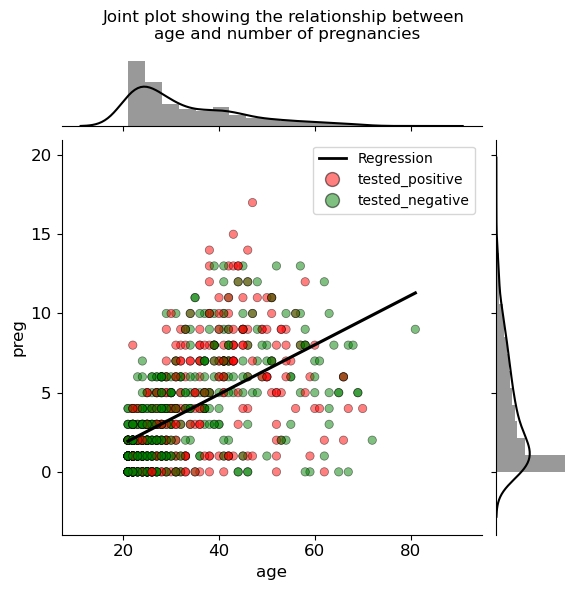

In [10]:
# We can see from the chart above that age and number of pregnancies (preg) have similar distributions...

# Question 1a (cont.) / Question 1b

# Now lets draw another chart, this time to explore if there is any correlation between age and number of times pregnant,
# and also to see if there are any patterns between these two input attributes and the output label (positive/negative diabetes)


# Reset scale
scale_plot()

# Convert target variable from numerical (1/0) to colours (r/g), so we can map positive/negative cases in the plot
targetvar_colours = targetvar_numeric.copy(deep=True)
targetvar_colours.loc[targetvar_colours['class'] == 1, 'class'] = 'r'
targetvar_colours.loc[targetvar_colours['class'] == 0, 'class'] = 'g'

# Plot regression line (line of best fit), without scatter
jointplot = sns.jointplot(data=dia_all, x ="age", y="preg", kind='regplot', ci=0, scatter=False, color='k')
ax = jointplot.ax_joint
# Plot scatter seperately, so we can group by positive/negative cases
ax.scatter(dia_all['age'], dia_all['preg'], c=targetvar_colours['class'], marker="o", alpha=0.5, linewidths=0.5, edgecolors='k')

# Create legend
legend_elements = [Line2D([0], [0], color='k', lw=2, label='Regression'),
                   Line2D([0], [0], marker='o', color='k', label='tested_positive', markerfacecolor='r', markersize=10, alpha=0.5, lw=0),
                   Line2D([0], [0], marker='o', color='k', label='tested_negative', markerfacecolor='g', markersize=10, alpha=0.5, lw=0)]
# Draw legend
ax.legend(handles=legend_elements, loc='upper right', fontsize="small")

# Set title
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle('Joint plot showing the relationship between \nage and number of pregnancies', fontsize=12)

# Show the plot
plt.show()


In [11]:
# Although it doesn't look like there is any obvious connection to the target label (positive/negative diabetes),
# there appears to be a positive correlation between the input attributes (age and number of pregnancies)


# Let's calculate the standardised covariance matrix of these two input variables and check
matrix = np.corrcoef(sourcevars['age'], sourcevars['preg'])
print(matrix)


[[1.         0.54434123]
 [0.54434123 1.        ]]


In [12]:
# The Pearson correlation coefficient is ~0.54 , suggesting a positive correlation between age and number of pregnancies...

# This is what we expected, as we can see the regression line in the jointplot has a positive gradient



# Task 2 - Classification

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


In [14]:
"""
Given a number of folds (k), testing input (X) and output (t) sets, and a classifier (DT or KNN),
this function performs k-fold cross validation and returns an ordered list of the average accuracies for each fold.

The data can also be standardised at each fold. The mean/std of the current training set is used to standardise both the
training set and the testing set.

The splits/partitions made by the cross validator are fixed, using the seed random_state = 1234.

"""
def kfold_validation_accuracy(X, t, k, classifier, standardise=False):
    
    # Build the kfold cross validator with n = k
    cv = KFold(n_splits=k, shuffle=True, random_state=1234)

    # Convert dataframes to numpy arrays
    X = X.to_numpy()
    t = t.to_numpy()

    # Type checking
    if type(classifier) not in {DecisionTreeClassifier, KNeighborsClassifier}:
        return
        
    accuracies = []
    for train, test in cv.split(X):
        
        if standardise:
            # Standardise input data
            scaler = preprocessing.StandardScaler().fit(X[train]) # Computes mean/std of training set for normalization
            X[train] = scaler.transform(X[train]) # Actually standardizes the data, using this scaler
            X[test] = scaler.transform(X[test]) # Standardise test set using training scalar (mean/std from training inputs)


        # Train model with training data
        classifier.fit(X[train], t[train].flatten()) # Flatten used to prevent DataConversion warning from shape (n,1) to (n,)
        # Predict the test output
        y = classifier.predict(X[test])

        # Compare actual testing output to predicted testing output
        accuracy = accuracy_score(t[test], y)
        
        # Collect accuracy at each fold
        accuracies.append(accuracy)

    return accuracies


In [15]:
# Question 2a


# Creating the models, using the seed random_state=1234 
gini_model = DecisionTreeClassifier(criterion="gini", random_state=1234)
ent_model  = DecisionTreeClassifier(criterion="entropy", random_state=1234)

# Perform the k-fold cross validation (no standardisation)
gini_accuracies = kfold_validation_accuracy(sourcevars, targetvar, k=5, classifier=gini_model)
ent_accuracies  = kfold_validation_accuracy(sourcevars, targetvar, k=5, classifier=ent_model)

# Create DataFrames and display the results
gini_data = {'Fold':range(1,6), 'Accuracy':gini_accuracies}
gini_df = pd.DataFrame(gini_data, columns= ['Fold', 'Accuracy'])
print("\n\nModel = DT, Criterion = Gini index, Data = Unstandardised\n\n", gini_df.to_string(index=False)) 
print("\nAverage accuracy: ", gini_df['Accuracy'].mean(), "\n\n")

ent_data = {'Fold':range(1,6), 'Accuracy':ent_accuracies}
ent_df = pd.DataFrame(ent_data, columns= ['Fold', 'Accuracy'])
print("\n\nModel = DT, Criterion = Entropy, Data = Unstandardised\n\n", ent_df.to_string(index=False))
print("\nAverage accuracy: ", ent_df['Accuracy'].mean(), "\n\n")




Model = DT, Criterion = Gini index, Data = Unstandardised

  Fold  Accuracy
    1  0.642857
    2  0.681818
    3  0.655844
    4  0.712418
    5  0.686275

Average accuracy:  0.6758424581953995 




Model = DT, Criterion = Entropy, Data = Unstandardised

  Fold  Accuracy
    1  0.688312
    2  0.746753
    3  0.701299
    4  0.712418
    5  0.647059

Average accuracy:  0.6991681521093286 




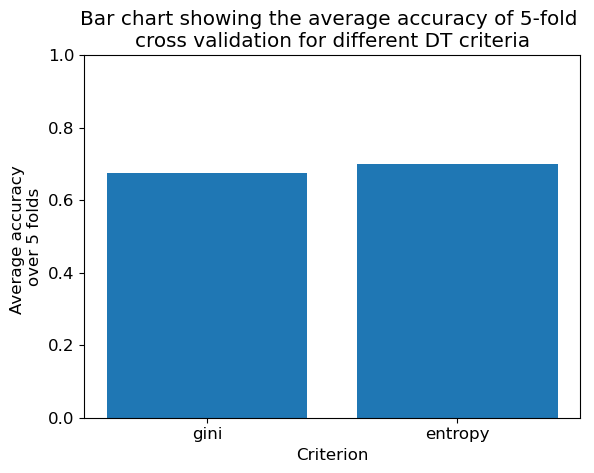

In [16]:
# Lets draw a bar chart of the averages to visualise the difference:


dt_accuracies = [gini_accuracies, ent_accuracies]
dt_averages = [sum(dt_accuracy) / len(dt_accuracy) for dt_accuracy in dt_accuracies]

fig, ax = plt.subplots()

plot = ax.bar(range(1,3), dt_averages)
plot = ax.set_title('Bar chart showing the average accuracy of 5-fold \ncross validation for different DT criteria')
plt.xlabel("Criterion")
plt.ylabel("Average accuracy \nover 5 folds")

# Add x-tick labels
plot = ax.set_xticks(range(1,3))
plot = ax.set_xticklabels(['gini', 'entropy'])

# Change y-axis
plot = plt.ylim(0, 1)


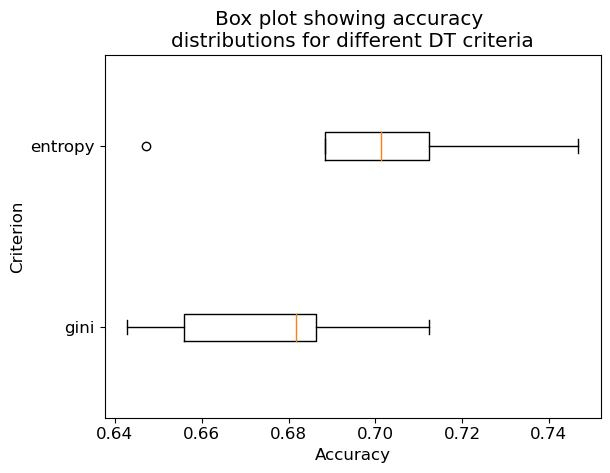

In [17]:
# Now lets explore the distributions further, using a boxplot..


fig, ax = plt.subplots()

# Prepare the data
data = [gini_accuracies, ent_accuracies]

# Build a boxplot with this data
ax.boxplot(data, showmeans=False, vert=False)

# Add title and axis labels
ax.set_title('Box plot showing accuracy \ndistributions for different DT criteria')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Criterion')

# Add y-tick labels
ax.set_yticks(range(1,3))
ax.set_yticklabels(['gini', 'entropy'])

# Show the plot
plt.show()


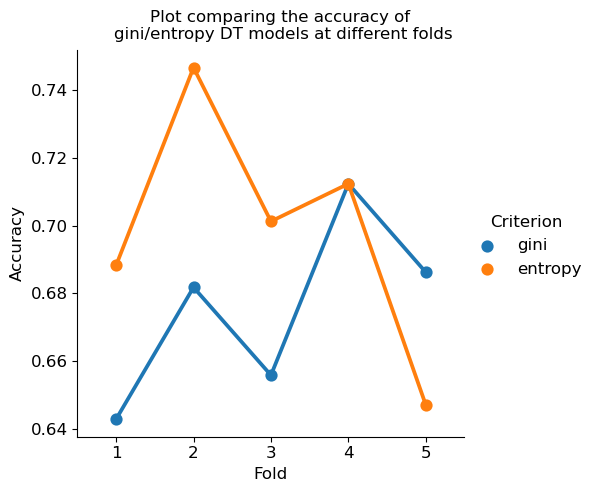

In [18]:
# Now lets see how they compare at each fold...
# We can make this comparison, because we used a fixed seed of random_state=1234, so they will have been cross-validated
# over the same splits.

# Prepare data
criterion = ["gini"]*len(gini_accuracies) + ["entropy"]*len(ent_accuracies)
accuracies = gini_accuracies + ent_accuracies
folds = [1,2,3,4,5]*2

# Create DataFrame
dt_data = {'Fold':folds, 'Criterion':criterion, 'Accuracies':accuracies}
dt_df = pd.DataFrame(dt_data, columns= ['Fold', 'Criterion', 'Accuracies'])

# Draw a pointplot by fold and criterion
plot = sns.catplot(data=dt_df, kind="point", x="Fold", y="Accuracies", hue="Criterion")
plot = plot.set_axis_labels("Fold", "Accuracy")

# Set title
plot = plt.subplots_adjust(top=0.9)
plot = plt.gcf().suptitle('Plot comparing the accuracy of \ngini/entropy DT models at different folds', fontsize=12)


In [19]:
# Question 2b

knn_accuracies = []

for k in [1, 3, 5]:
    # Perform k-fold crossvalidation (w/standardisation)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_accuracy = kfold_validation_accuracy(sourcevars, targetvar, k=5, classifier=knn, standardise=True)
    knn_accuracies.append(knn_accuracy)
    
    # Create DataFrames and display the results
    k_data = {'Fold':range(1,6), 'Accuracy':knn_accuracy}
    k_df = pd.DataFrame(k_data, columns= ['Fold', 'Accuracy'])
    print("\n\nModel = KNN, k =", k, ", Data = Standardised\n\n", k_df.to_string(index=False)) 
    print("\nAverage accuracy: ", k_df['Accuracy'].mean(), "\n\n")




Model = KNN, k = 1 , Data = Standardised

  Fold  Accuracy
    1  0.655844
    2  0.727273
    3  0.707792
    4  0.686275
    5  0.699346

Average accuracy:  0.6953060011883542 




Model = KNN, k = 3 , Data = Standardised

  Fold  Accuracy
    1  0.694805
    2  0.779221
    3  0.701299
    4  0.758170
    5  0.771242

Average accuracy:  0.7409472880061114 




Model = KNN, k = 5 , Data = Standardised

  Fold  Accuracy
    1  0.727273
    2  0.792208
    3  0.707792
    4  0.673203
    5  0.764706

Average accuracy:  0.7330362448009508 




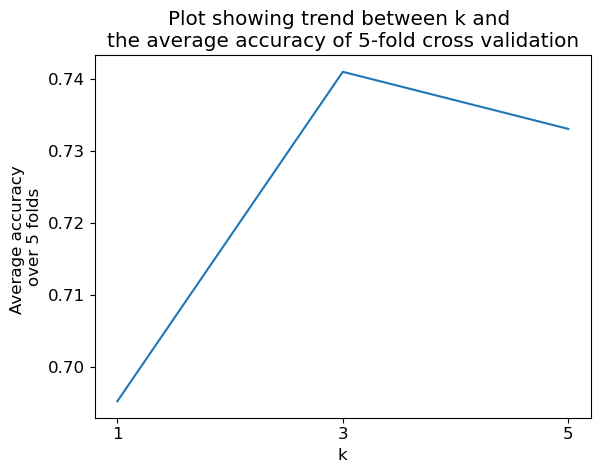

In [20]:
# Lets plot the averages to see if there is any trend:


knn_averages = [sum(knn_accuracy) / len(knn_accuracy) for knn_accuracy in knn_accuracies]

fig, ax = plt.subplots()

plot = ax.plot(range(1,4), knn_averages)
plot = ax.set_title('Plot showing trend between k and \nthe average accuracy of 5-fold cross validation')
plt.xlabel("k")
plt.ylabel("Average accuracy \nover 5 folds")

# Add x-tick labels
plot = ax.set_xticks(range(1,4))
plot = ax.set_xticklabels(['1', '3', '5'])


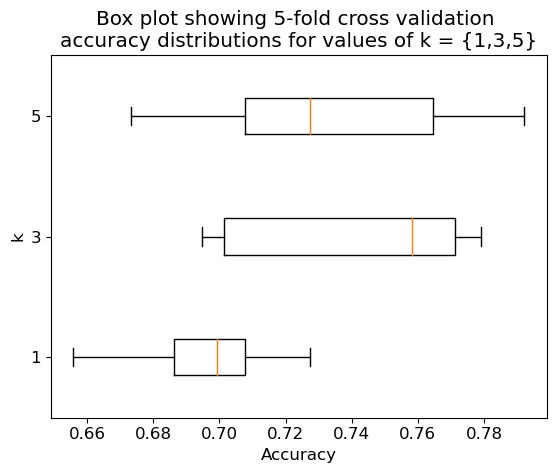

In [21]:
# And again, lets explore the distributions using a boxplot..


fig, ax = plt.subplots()

# Build a boxplot with the data
ax.boxplot(knn_accuracies, showmeans=False, vert=False)

# Add title and axis labels
ax.set_title('Box plot showing 5-fold cross validation \naccuracy distributions for values of k = {1,3,5}')
ax.set_xlabel('Accuracy')
ax.set_ylabel('k')

# Add y-tick labels
ax.set_yticks(range(1,4))
ax.set_yticklabels(['1', '3', '5'])

# Show the plot
plt.show()


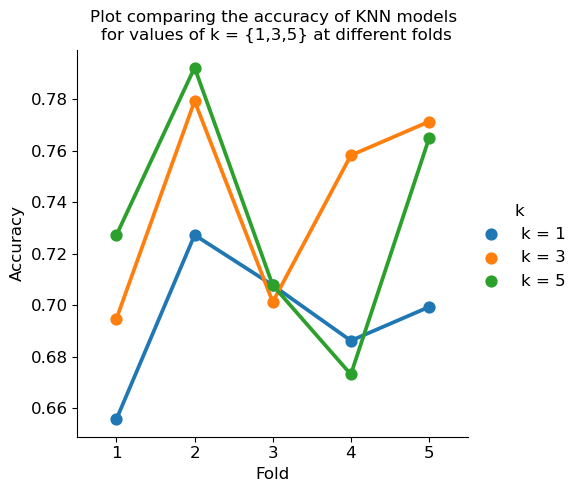

In [22]:
# Now lets see how they compare at each fold...

# Prepare data
k = ["k = 1"]*len(knn_accuracies[0]) + ["k = 3"]*len(knn_accuracies[1]) + ["k = 5"]*len(knn_accuracies[2])
accuracies = knn_accuracies[0] + knn_accuracies[1] + knn_accuracies[2]
folds = [1,2,3,4,5]*3

# Create DataFrame
knn_data = {'Fold':folds, 'k':k, 'Accuracies':accuracies}
knn_df = pd.DataFrame(knn_data, columns= ['Fold', 'k', 'Accuracies'])

# Draw a pointplot by fold and criterion
plot = sns.catplot(data=knn_df, kind="point", x="Fold", y="Accuracies", hue="k")
plot = plot.set_axis_labels("Fold", "Accuracy")

# Set title
plot = plt.subplots_adjust(top=0.9)
plot = plt.gcf().suptitle('Plot comparing the accuracy of KNN models \nfor values of k = {1,3,5} at different folds', fontsize=12)


# Task 3 - Classification parameters DT

In [23]:
from sklearn.model_selection import train_test_split


In [24]:
"""
Given input (X) and output (t) sets, a split percentage, and a DT classifier, this function splits the sets into
training and testing sets, trains the classifier, and returns the classifiers accuracy against the testing set.

The data can also be standardised before training. The mean/std of the training set is used to standardise both the
training set and the testing set.

The split is fixed, using the seed random_state = 1234.

"""
def DT_split_accuracy(X, t, split, classifier, standardise=False):

    # Type checking
    if type(classifier) is not DecisionTreeClassifier:
        return
    
    # Split dataset into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=split, random_state=1234)
    
    if standardise:
        # Standardise input data
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    # Train model with training data
    classifier.fit(X_train, y_train)
    # Predict the test output
    y = classifier.predict(X_test)
    
    # Compare actual testing output to predicted testing output
    accuracy = accuracy_score(y_test, y)
 
    return accuracy


In [25]:
# Question 3a 


min_samples_accuracies = []
min_samples = range(2,6)
split = 0.3

# Evaluate accuracy of DT with min_samples_leaf = {2, 3, 4, 5}
for min_samples_split in min_samples:
    classifier = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=1234)
    accuracy = DT_split_accuracy(sourcevars, targetvar, split, classifier)
    min_samples_accuracies.append(accuracy)

# Create DataFrames and display the results
min_split_data = {'min_samples_split':min_samples, 'Accuracy':min_samples_accuracies}
min_split_df = pd.DataFrame(min_split_data, columns= ['min_samples_split', 'Accuracy'])
print("\n\nModel = DT, Criterion = Gini, Data = Unstandardised\n\n", min_split_df.to_string(index=False), "\n")
    



Model = DT, Criterion = Gini, Data = Unstandardised

  min_samples_split  Accuracy
                 2  0.701299
                 3  0.701299
                 4  0.696970
                 5  0.692641 



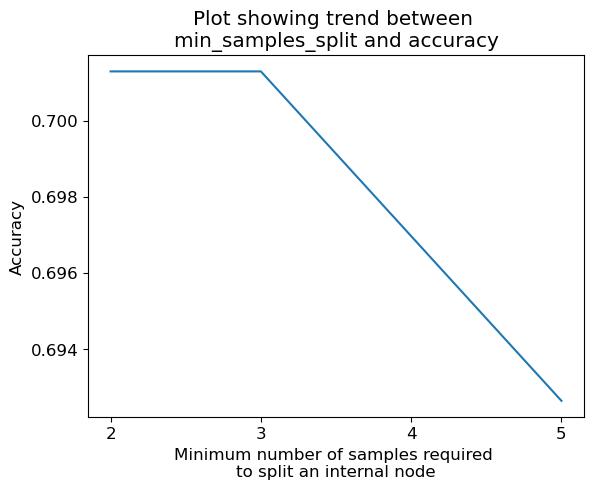

In [26]:
# Lets plot the accuracies to see if there is any trend:


fig, ax = plt.subplots()

plot = ax.plot(min_samples, min_samples_accuracies)
plot = ax.set_title('Plot showing trend between \nmin_samples_split and accuracy')
plt.xlabel("Minimum number of samples required \nto split an internal node")
plt.ylabel("Accuracy")
plot = ax.set_xticks(range(2,6))


In [27]:
# Question 3b


max_depth_accuracies = []
max_depths = range(3,7)
split = 0.3

for max_depth in max_depths:
    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=1234)
    accuracy = DT_split_accuracy(sourcevars, targetvar, split, classifier, standardise=False)
    max_depth_accuracies.append(accuracy)

# Create DataFrames and display the results
max_depth_data = {'max_depth':max_depths, 'Accuracy':max_depth_accuracies}
max_depth_df = pd.DataFrame(max_depth_data, columns=['max_depth', 'Accuracy'])
print("\n\nModel = DT, Criterion = Gini, Data = Unstandardised\n\n", max_depth_df.to_string(index=False), "\n")




Model = DT, Criterion = Gini, Data = Unstandardised

  max_depth  Accuracy
         3  0.714286
         4  0.735931
         5  0.714286
         6  0.718615 



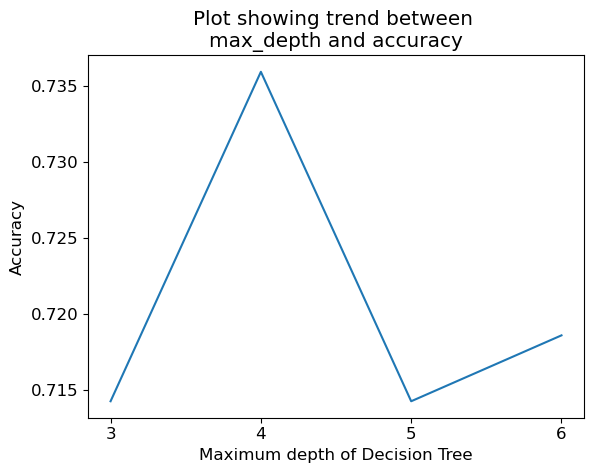

In [28]:
# Again, lets plot the accuracies to see if there is any trend:

fig, ax = plt.subplots()

plot = ax.plot(max_depths, max_depth_accuracies)
plot = ax.set_title('Plot showing trend between \nmax_depth and accuracy')
plt.xlabel("Maximum depth of Decision Tree")
plt.ylabel("Accuracy")
plot = ax.set_xticks(range(3,7))


# Reflection

See attached Reflection.pdf file.